## Contents

1. Note on Units
2. Camera Modules and Instrument
    * Creating a Module
    * Creating an Instrument
3. Scanning
    * SkyPattern
    * TelescopePattern
4. Observation

In [1]:
import json
import importlib
import math

import numpy as np
import pandas as pd
import astropy.units as u

import scanning
import scanning.visualization as vis

# Note on Units

See [astropy.units](https://docs.astropy.org/en/stable/units/index.html#module-astropy.units.si) 
for a list of unit names that you can use. Notable ones include:
 * angle-like: 
    * ``arcmin``/``arcminute``
    * ``arcsec``/``arcsecond``
    * ``deg``/``degree`` (usually the default)
    * ``hourangle``
    * ``rad``/``radian``
 * time-like: 
    * ``h``/``hour``/``hr``
    * ``min``/``minute`` 
    * ``s``/``second`` (usually the default)

In [23]:
# when passing in values, there exists default units, but specific units can also be passed using astropy.units:
mod_unit = scanning.Module(wavelength=0.0005*u.m)

# or as a string
mod_unit = scanning.Module(wavelength='0.0005 m')

In [24]:
# when receiving values with units, convert to a regular numeric type after unit conversion
print(mod_unit.ang_res)
print(mod_unit.ang_res.to(u.arcsec).value) # using import astropy.units as u
print(mod_unit.ang_res.to('arcsec').value) # using a string

0.005733544455586236 deg
20.64076004011045
20.64076004011045


# Camera Modules and Instruments

### Creating a Module

The `Module` class allows one to represent a camera module, which consists of three wafers each consisiting of three rhombuses. 

The following is the algorithm (from `eor_spec_models.detectorpixelpositions.writexycoords.py`) for generating a module by passing a `F_Lambda` and `wavelength` or `freq`. See source code for more details.
1. Each detector wafer's center is 72mm from the center of the focal plane. Let wafer 1 be shifted in +x by 72mm, and wafer 2 and 3 be rotated to 120, 240 degrees from the x-axis respectively. The distance of the nearest pixel from the center of the wafer is 1.5*2.75mm. 
2. Given that a 280GHz module has 24 rows and columns and a pitch of 2.75mm, we can use the ratio between 280 and the user-specified `freq` or `wavelength` to find the rows, columns, and pitch of any module. 
3. Beam size is calculated as : `F_lambda*math.degrees((3*10**8)/(freq*10**9)/6)` (telescope's diameter is 6 metres). 

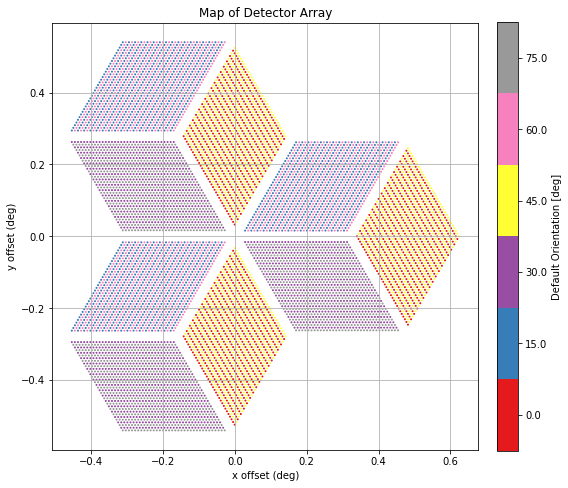

In [2]:
# you can create a module by passing in an F_lambda and a freq/wavelength 
mod1 = scanning.Module(freq=400, F_lambda=1.2)
vis.plot_module(mod1, mode='pol')

In [3]:
# there are also predefined Module objects such as:
scanning.SFH # 860 GHz
scanning.CMBPol # 350 GHz
scanning.EoRSpec # 262.5, 262.5, 367.5 GHz
scanning.Mod280 # 280 GHz
pass

---
You can save this `Module` object's data as a csv file and specify which columns you would like to save. To return the data as a dictionary, do not specify a path in the first argument. To re-generate the same object, pass that csv file or dictionary into `Module()`. Note that all columns (`x`, `y`, `pol`, `rhombus`, `wafer`) are recommended to be passed. 

In [4]:
# you can save the module data with specific columns and units
# go to sample_module.csv to see the format
mod1.save_data('sample_module.csv', columns={'x': 'arcsec', 'y': 'arcsec', 'pol': 'deg', 'rhombus': None, 'wafer': None})
print(pd.read_csv('sample_module.csv').head())

# you can pass it again in the future
mod2 = scanning.Module('sample_module.csv', units={'x': 'arcsec', 'y': 'arcsec', 'pol': 'deg'})

             x           y   pol  rhombus  wafer
0  1223.525328    0.000000   0.0        0      0
1  1238.995188   26.794584  45.0        0      0
2  1254.465049   53.589169   0.0        0      0
3  1269.934909   80.383753  45.0        0      0
4  1285.404770  107.178337   0.0        0      0


---
There are several properties and attributes one can extract from a `Module` object. Any of the data columns can be accessed like an attribute. 

In [5]:
# angular resolution has a unit associated with it
print('ang_res =', mod1.ang_res)

# polarizations have a unit associated with it 
print('pol =', mod1.pol)

# wafers do not have a unit associated with it
print('wafer =', mod1.wafer)

ang_res = 0.008594366926962348 deg
pol = [ 0. 45.  0. ... 75. 30. 75.] deg
wafer = [0 0 0 ... 2 2 2]


### Creating an Instrument

`Instrument` (with `PrimeCam` and `ModCam` being specific subclasses) allows one to configure multiple `Module` objects into any location relative to the boresight. You can fill up an `Instrument` with `Module` objects and specify its location in polar coordinates and rotation. 

In [6]:
# Here, we create an empty PrimeCam instrument.
# By default, instr_offset (x and y offset of the instrument relative to the boresight) and instr_rot is 0. 
prime_cam1 = scanning.PrimeCam()
prime_cam1

instrument: offset [0. 0.] deg, rotation 0.0 deg
------------------------------------
empty

In [7]:
# add modules!
prime_cam1.add_module(mod1, location=(1.78, 90), identifier='mod1') # location in terms of (dist, theta) in degrees
prime_cam1.add_module(mod2, location='i1', identifier='mod2')       # location in terms of a pre-defined slot
prime_cam1.add_module('Mod280', location='i2')                      # a pre-defined module str option
prime_cam1.add_module('SFH', location='c', mod_rot=30)              # adding a rotation to the module

# change the instr offset/rotation!
prime_cam1.instr_offset = (1, 1)
prime_cam1

instrument: offset [1. 1.] deg, rotation 0.0 deg
------------------------------------
mod1 
 (r, theta) = (1.78, 90.0), rotation = 0.0
mod2 
 (r, theta) = (1.78, -90.0), rotation = 0.0
Mod280 
 (r, theta) = (1.78, -30.0), rotation = 0.0
SFH 
 (r, theta) = (0.0, 0.0), rotation = 30.0

In [8]:
# change modules 
prime_cam1.change_module('Mod280', new_mod_rot=30, new_location=(0, 0))
prime_cam1.change_module('mod1', new_location='i5')
prime_cam1.change_module('mod2', new_identifier='mod2_renamed')

# delete modules
prime_cam1.delete_module('SFH')
prime_cam1

instrument: offset [1. 1.] deg, rotation 0.0 deg
------------------------------------
mod1 
 (r, theta) = (1.78, 150.0), rotation = 0.0
Mod280 
 (r, theta) = (0.0, 0.0), rotation = 30.0
mod2_renamed 
 (r, theta) = (1.78, -90.0), rotation = 0.0

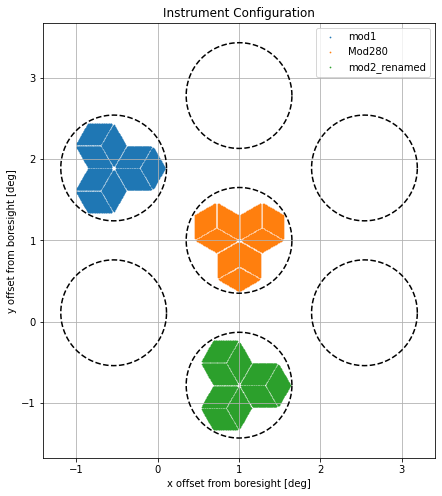

In [9]:
# plot its configuration 
vis.instrument_config(prime_cam1)

---
You can save this `Instrument` object's data as a json file. It will contain the `instr_offset`, `instr_rot`, and all info about each `Module` object. To return the data as a dictionary, do not specify a path in the first argument. To re-generate the same `Instrument` object, pass that json file or dictionary into the constructor. 

Other than that, there are various properties, attributes, and getters one can get from an `Instrument` object. Similarly to modules (see above), getters will return a `Quantity` object. 

In [10]:
# save the configuration so that it can be used later 
prime_cam1.save_data('PrimeCam.json')
prime_cam2 = scanning.PrimeCam('PrimeCam.json')

In [11]:
# get all slot locations of the instrument
print(prime_cam1.slots)

# get location, mod_rot of a module
print('location =', prime_cam1.get_location('mod1'))
print('mod_rot =', prime_cam1.get_mod_rot('mod1'))

# return the module object back
# you can also choose to apply instrument/module rotations and offsets to the return Module
prime_cam1.get_module('mod1', with_mod_rot=True, with_instr_rot=True)

{'c': <Quantity [0., 0.] deg>, 'i1': <Quantity [  1.78, -90.  ] deg>, 'i2': <Quantity [  1.78, -30.  ] deg>, 'i3': <Quantity [ 1.78, 30.  ] deg>, 'i4': <Quantity [ 1.78, 90.  ] deg>, 'i5': <Quantity [  1.78, 150.  ] deg>, 'i6': <Quantity [   1.78, -150.  ] deg>}
location = [  1.78 150.  ] deg
mod_rot = 0.0 deg


# Scanning

### SkyPattern (path in RA/DEC offsets)

It is useful to represent the path of the detector array on the sky. `SkyPattern` can represent the RA/DEC offsets of an arbitray pattern, which can be used on any source. 

`Daisy` is a specific example of such a pattern, as shown below. `Daisy` is optimized for point sources. Pass in appropriate parameters to generate a pattern. Those parameters can then be saved as a json file and passed into the constructor to re-generate the same pattern. 

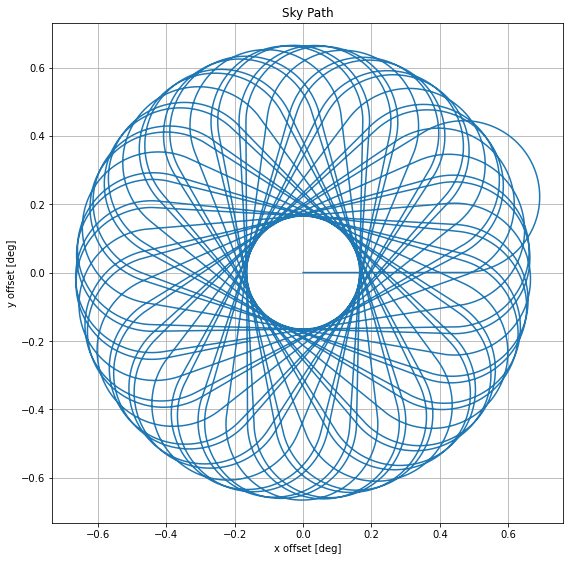

In [13]:
# Initialize a Daisy pattern by passing in keywords
daisy1 = scanning.Daisy(
    velocity=1/3, start_acc=0.2, 
    R0=0.47, Rt=800*u.arcsec, Ra=600*u.arcsec, 
    T=300, sample_interval=1/400
)

vis.sky_path(daisy1)

In [14]:
# You can save the parameters so that the same pattern can be used later
daisy1.save_param('Daisy.json')
daisy2 = scanning.Daisy('Daisy.json', Ra=1200*u.arcsec) # you can use keywords to overwrite any parameters 

---
`Pong` is another example of a sky pattern, but optimized for small fields. Note that unlike `Daisy`, the `Pong` pattern is repeatable since its end location is the same as its start location. Thus, we can repeat the pattern however many times. 

num_repeat = 2


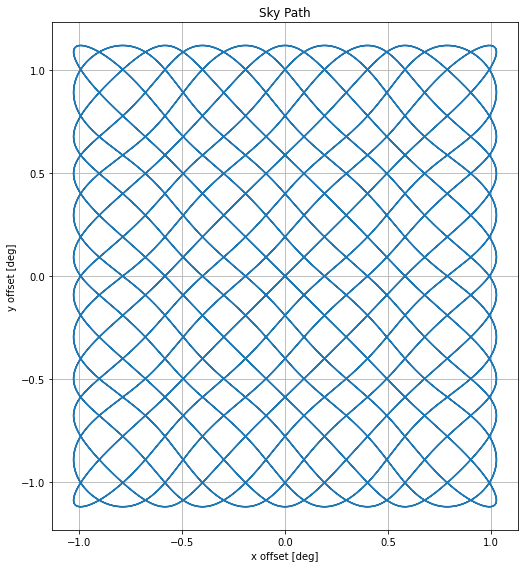

In [15]:
# Similarly Initialize a Pong Pattern

# You can pass a max_scan_duration, which repeats the same pong pattern up until the scan duration is less than max_scan_duration
# or you can directly pass num_repeat
pong1 = scanning.Pong(
    num_term=4, 
    width=2, height=2, spacing='500 arcsec', 
    velocity=1/2, sample_interval=1/400,
    angle=0,
    max_scan_duration=360
)
print('num_repeat =', pong1.param['num_repeat'])
vis.sky_path(pong1)

---
I've shown how to save the parameters of the pattern, but you can also save the data as a csv file. To return the data as a dictionary, do not specify a path in the first argument.

Note that if done this way, information about the parameters are not saved, so this csv file cannot be passed into the same child-class constructor (such as `Daisy` or `Pong`). Instead, you can pass the csv file or dictionary so long as `time_offset`, `x_coord`, and `y_coord` are columns) into the `SkyPattern` constructor. 

In [16]:
# For any SkyPattern instance, you can save its data as a csv file 
# and specify any columns (default x_coord, y_coord, time_offset)
# Also specifiy whether to include repetitions for a repeatable pattern like Pong
pong1.save_data('Pong.csv', include_repeats=False, columns={'time_offset': 's', 'x_coord': 'arcsec', 'y_coord': 'arcsec'}) 
print(pd.read_csv('Pong.csv').head())

# You can also create an arbitrary SkyPattern given time_offset, x_coord, and y_coord
# and you can specify whether this is repeatable as well.
sky_pattern1 = scanning.SkyPattern('Pong.csv', repeatable=True, num_repeat=1, units = {'time_offset': 's', 'x_coord': 'arcsec', 'y_coord': 'arcsec'})

   time_offset    x_coord    y_coord
0       0.0000   0.000000   0.000000
1       0.0025   2.932463   2.932463
2       0.0050   5.864953   5.864948
3       0.0075   8.797497   8.797478
4       0.0100  11.730121  11.730075


---
There are several properties and attributes one can extract from a `SkyPattern` object. Any of the data columns and parameters can be accessed like an attribute. Other kinematics such as velocity, acceleration, and jerk are also accessible. See section on Units for unit conversions.

In [17]:
# a dictionary of parameters can be accessed
print('Pong: param =', pong1.param)

# stored data can be accessed like an attribute (all)
print()
print('time_offset =', sky_pattern1.time_offset)
print('x_coord =', sky_pattern1.x_coord)

# other kinematics data (vel, acc, jerk) can be accessed like an attribute (all)
print()
print('x_vel =', sky_pattern1.x_vel)
print('acc =', sky_pattern1.acc) # total acc
print('distance = ', sky_pattern1.distance)

# total scan time, sample_interval
print()
print('scan_duration =', sky_pattern1.scan_duration)
print('sample_interval =', sky_pattern1.sample_interval)

Pong: param = {'num_term': 4, 'width': <Quantity 2. deg>, 'height': <Quantity 2. deg>, 'spacing': <Quantity 0.13888889 deg>, 'velocity': <Quantity 0.5 deg / s>, 'sample_interval': <Quantity 0.0025 s>, 'angle': <Quantity 0. deg>, 'num_repeat': 2}

time_offset = [0.000000e+00 2.500000e-03 5.000000e-03 ... 1.466600e+02 1.466625e+02
 1.466650e+02] s
x_coord = [ 0.          0.00081457  0.00162915 ... -0.00217222 -0.00135763
 -0.00054305] deg

x_vel = [0.32582926 0.32583074 0.32583521 ... 0.32583983 0.32583339 0.32583091] deg / s
acc = [0.00077693 0.00155382 0.0031075  ... 0.00414314 0.00233066 0.00129485] deg / s2
distance =  [0.         0.00115198 0.00230397 ... 0.00307197 0.00191997 0.00076799] deg

scan_duration = 146.66749999990287 s
sample_interval = 0.0024999999999983443 s


### TelescopePattern (path in AZ/EL)

A `TelescopePattern` stores time offset, sidereal time, azimuth coordinates, and elevation coordinates. Typically, this can be interpreted as the path of the boresight for a particular scan. 

One way of intializing a `TelescopePattern` is by passing a `SkyPattern` instance along with observational data that has the right ascension and declination of your source, and some way to initialize time (see below). Similar to `SkyPattern`, you can save the parameters of observation to use later on. 

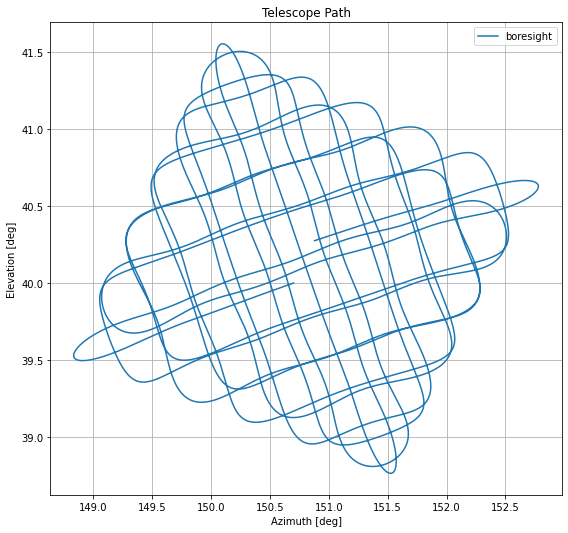

In [18]:
# Initialize a TelescopePattern by passing a SkyPattern object
# Along with and ra and dec, pass either a:
    # start_datetime
    # start_hrang (hourangle)
    # start_lst (sidereal time)
    # or start_elev (with option to choose moving_up = True (default) or False)
    
t1 = scanning.TelescopePattern(
    sky_pattern1, 
    start_ra=60, start_dec=-60, start_elev=40
)
vis.telescope_path(t1)

# save the parameters of this observation
t1.save_param('Observation.json')

---
Suppose your `SkyPattern` object is not for the boresight of the telescope, but for one of the modules. This is so that your chosen module is the one that generates the sky pattern, but you receive the AZ/EL values of the boresight (which is what commands the telescope). 

Do this by passing an `Instrument` object and choosing a module. The module parameter `module` can be a slot location, module identifier, or a (dist, theta). 

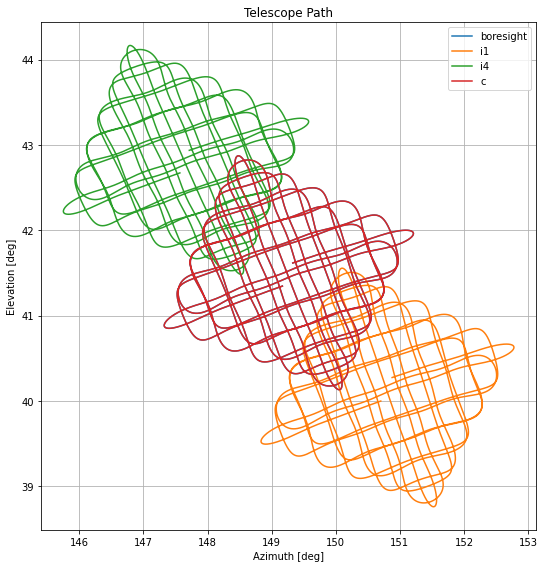

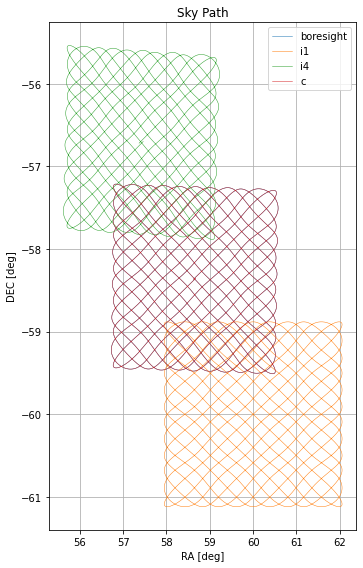

In [19]:
# Specify which module in a passed Instrument object to apply the pattern on.
t2 = scanning.TelescopePattern(
    sky_pattern1, 
    instrument=prime_cam1, data_loc='i1', 
    obs_param='Observation.json'
)
vis.telescope_path(t2, module=['boresight', 'i1', 'i4', 'c'])
vis.sky_path(t2, module=['boresight', 'i1', 'i4', 'c'])

---
Now that you have an initialized `TelescopePattern`, suppose you want to view the AZ/EL coordinates of any module away from the boresight. The following returns a new `TelescopePattern` where the stored AZ/EL coordinates are that of the specified module. Note that this new object does not retain instrument information, since the idea of a boresight is not applicable anymore. 

In [20]:
t2_i1 = t2.view_module('i1')

---
There are several properties, attributes, and getters one can extract from a `TelescopePattern` object. Any of the data columns and parameters can be accessed like an attribute. Other kinematics such as velocity, acceleration, and jerk are also accessible. Among other things include hour angle, rotation angle, and ra/dec coordinates. 

You can also get the corresponding `SkyPattern` object (which is in terms of ra/dec offsets not coordinates). Note that this may be different to the `SkyPattern` object passed during intialization due to boresight/module locations. See section on Units for unit conversions.

In [21]:
# access the boresight's data as an attribute
print('lst =', t2.lst)
print('az_coord =', t2.az_coord)

# access other kinematics
print()
print('alt_vel =', t2.alt_vel)
print('acc =', t2.acc) # total acc
print('hour_angle =', t2.hour_angle)
print('rot_angle =', t2.rot_angle)
print('ra_coord =', t2.ra_coord)

# You can also get the boresight as a SkyPattern (recall it is in terms of x & y offset, not ra/dec)
print()
sky_pattern_t2 = t2.get_sky_pattern()
#vis.sky_path(sky_pattern_t2)

lst = [0.76223066 0.76223135 0.76223205 ... 0.80308109 0.80308178 0.80308248] hourangle
az_coord = [149.16730608 149.16590933 149.16451259 ... 149.33249014 149.33108163
 149.32967316] deg

alt_vel = [-0.14742991 -0.14744281 -0.14746939 ... -0.14255085 -0.1425719
 -0.14258281] deg / s
acc = [0.00520018 0.00791387 0.01096115 ... 0.01128811 0.00809529 0.00529832] deg / s2
hour_angle = [20.85404082 20.85394048 20.85384013 ... 20.89187758 20.89177737
 20.89167716] hourangle
rot_angle = [337.24039427 337.23782145 337.23524857 ... 338.1039192  338.10134765
 338.0987761 ] deg
ra_coord = [58.62284752 58.62436316 58.62587882 ... 58.66805259 58.66956619
 58.67107978] deg



---
Similar to `SkyPattern`, you can save the data as a csv file and pass it into the constructor to initialize it again. See docstrings for more information. 

In [22]:
# you can also save the data to use again in the future
t2.save_data('TelescopePattern.csv', columns=['time_offset', 'lst', 'az_coord', 'alt_coord'])
print(pd.read_csv('TelescopePattern.csv').head())

# this also shows how one can initialize a TelescopePattern given az/el coordinates
# if the data includes sidereal time, observation parameters are not needed
t3 = scanning.TelescopePattern('TelescopePattern.csv')

   time_offset       lst    az_coord  alt_coord
0       0.0000  0.762231  149.167306  41.346607
1       0.0025  0.762231  149.165909  41.346239
2       0.0050  0.762232  149.164513  41.345870
3       0.0075  0.762233  149.163116  41.345501
4       0.0100  0.762233  149.161719  41.345133


# Observation

An `Observation` object represents an observation of a source(s) for a particular time range, and can be used to find the ideal time for observation.

(dec=30.0N):  [[-0.5279999999999898, 1.9520000000000124]]
(dec=0.0N):  [[-1.1039999999999903, 3.792000000000014]]
(dec=-20.0N):  [[-4.319999999999993, -2.6079999999999917], [1.0560000000000116, 1.7280000000000122]]


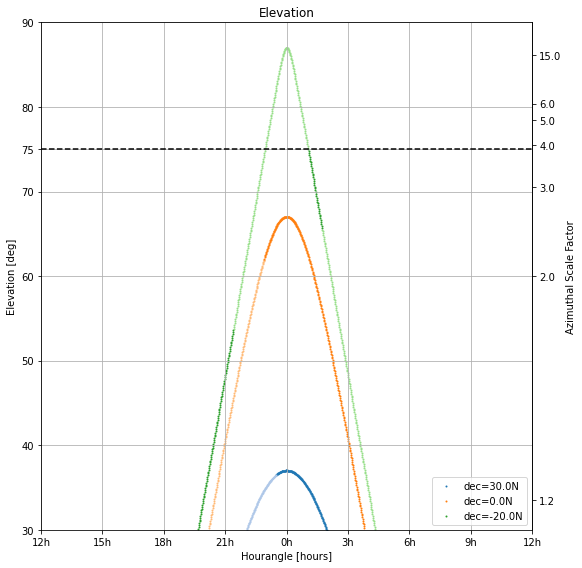

In [26]:
# pass a list of declinations
# defaults to an hour angle range of -12 to 12
obs1 = scanning.Observation([30, 0, -20])

# search for when the objects fit the following condition
valid_ranges = obs1.filter(min_elev=30, max_elev=75, min_rot_rate=15)
vis.filter_observation(obs1, plot='elevation', min_elev=30, max_elev=75, min_rot_rate=15)

(0.0h 30.0N):  [[datetime.datetime(2001, 12, 9, 19, 46, 33, 600000), datetime.datetime(2001, 12, 9, 22, 13, 26, 400000)]]
(2.0h 0.0N):  [[datetime.datetime(2001, 12, 9, 0, 0), datetime.datetime(2001, 12, 9, 2, 8, 38, 400000)], [datetime.datetime(2001, 12, 9, 21, 11, 2, 400000), datetime.datetime(2001, 12, 9, 23, 58, 4, 800000)]]
(4.0h -20.0N):  [[datetime.datetime(2001, 12, 9, 1, 24, 28, 800000), datetime.datetime(2001, 12, 9, 2, 3, 50, 400000)], [datetime.datetime(2001, 12, 9, 19, 58, 4, 800000), datetime.datetime(2001, 12, 9, 21, 39, 50, 400000)]]


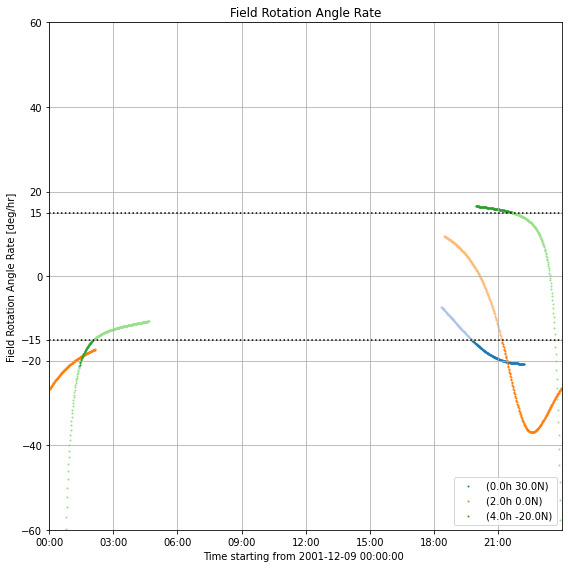

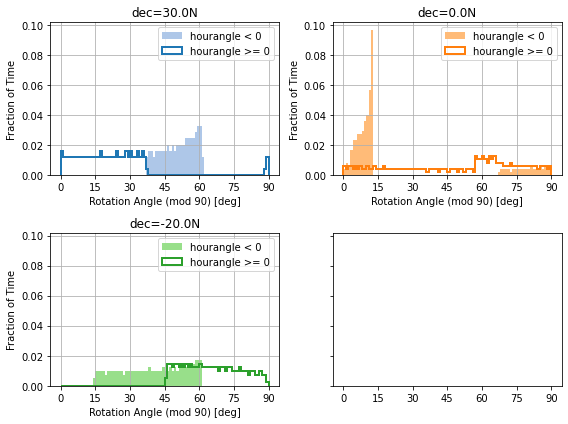

In [27]:
# suppose I want to look at a particular date 
obs2 = scanning.Observation([30, 0, -20], datetime_range=['2001-12-09', '2001-12-10'], ra=[0, 2, 4]*u.hourangle)

valid_ranges = obs2.filter(min_elev=30, max_elev=75, min_rot_rate=15)
vis.filter_observation(obs2, plot='rot_rate', min_elev=30, max_elev=75, min_rot_rate=15)

# get a histogram of field rotation values
vis.field_rotation_hist(obs1, min_elev=30, max_elev=75)